In [ ]:
!pip install clip datasets

In [ ]:
import json
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import clip
from transformers import CLIPProcessor, CLIPModel
import datasets
from tqdm import tqdm
from torchvision import transforms


In [ ]:
from datasets import load_dataset

data = load_dataset('Magneto/caption_for_mars_and_rover_image_size_1024')

In [ ]:
# View the dataset structure
print(data)

# Access train and test sets
train_dataset = data['train']
test_dataset = data['test']

DatasetDict({
    train: Dataset({
        features: ['url', 'image_path', 'short_caption', 'long_caption', 'image'],
        num_rows: 8797
    })
    validation: Dataset({
        features: ['url', 'image_path', 'short_caption', 'long_caption', 'image'],
        num_rows: 1885
    })
    test: Dataset({
        features: ['url', 'image_path', 'short_caption', 'long_caption', 'image'],
        num_rows: 1886
    })
})


In [ ]:
len(train_dataset) + len(test_dataset)

10683

In [ ]:
import matplotlib.pyplot as plt
image = train_dataset[100]['image']
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to CLIP input size
    transforms.ToTensor()  # Convert to torch tensor
])
image = transform(image)

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
class Image_caption_dataset():
  def __init__(self, train_dataset, caption="long"):
    self.caption = caption
    self.train_dataset = train_dataset
    self.transform = transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to CLIP input size
    transforms.ToTensor()  # Convert to torch tensor
    ])

  def __len__(self):
    return len(train_dataset)

  def __getitem__(self, idx):
    image = train_dataset[idx]["image"]

    if image.mode == "L":
      image = image.convert("RGB")

    image = transform(image)

    if self.caption == "short":
      text = train_dataset[idx]["short_caption"]
    elif self.caption == "long":
      text = train_dataset[idx]["long_caption"]
    else:
      raise "Wrong Stuff"

    return image, text

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

batch_size = 128
train_set = Image_caption_dataset(train_dataset, caption="short")
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

model = model.to(device)
torch.cuda.empty_cache()
losses = []
num_epochs = 5
for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for batch in pbar:
        optimizer.zero_grad()

        images,texts = batch

        inputs = processor(text=texts, images=images, return_tensors="pt", padding=True, do_rescale=False)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Forward pass
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text
        # Compute loss
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)


        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
        losses.append(total_loss)
        # Backward pass
        total_loss.backward()
        optimizer.step()
        # if device == "cpu":
        #     optimizer.step()
        # else :
        #     convert_models_to_fp32(model)
        #     optimizer.step()
        #     clip.model.convert_weights(model)

        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

Epoch 4/5, Loss: 2.4343: 100%|██████████| 69/69 [04:56<00:00,  4.29s/it]


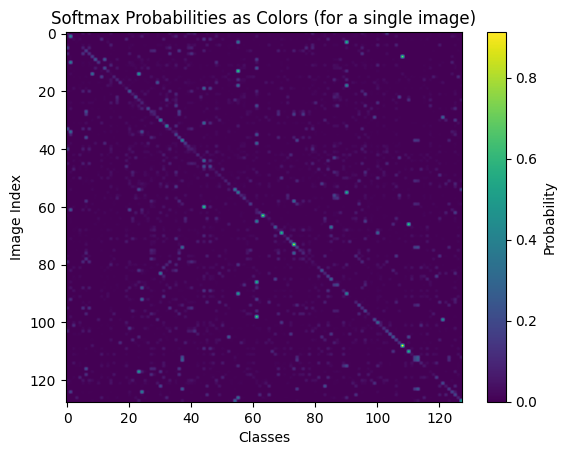

In [ ]:
del inputs
torch.cuda.empty_cache()

images, text = next(iter(train_dataloader))
inputs = processor(text=text, images=images, return_tensors="pt", padding=True, do_rescale=False)
inputs = inputs.to(device)

outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
logits_per_text = outputs.logits_per_text

probs = logits_per_image.softmax(dim=1)  # Softmax to get probabilities


# Create a grid plot for the probabilities (interpreting it as a color-coded heatmap)
plt.imshow(probs.cpu().detach().numpy(), cmap='viridis', aspect='auto')  # Reshape into a 1D grid
plt.colorbar(label='Probability')
plt.title("Softmax Probabilities as Colors (for a single image)")
plt.xlabel("Classes")
plt.ylabel("Image Index")
plt.show()

In [ ]:
batch_size = 64
test_set = Image_caption_dataset(test_dataset, caption="short")
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        }, f"/content/drive/MyDrive/CLIP_Models/model_10.pt")

In [ ]:
model_path = "/content/drive/MyDrive/CLIP_Models/model_10.pt"

# Load the CLIP model architecture
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Load the model weights from your .pt file
model.load_state_dict(torch.load(model_path)['model_state_dict'])



<ipython-input-21-d468faaaccf5>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


<All keys matched successfully>

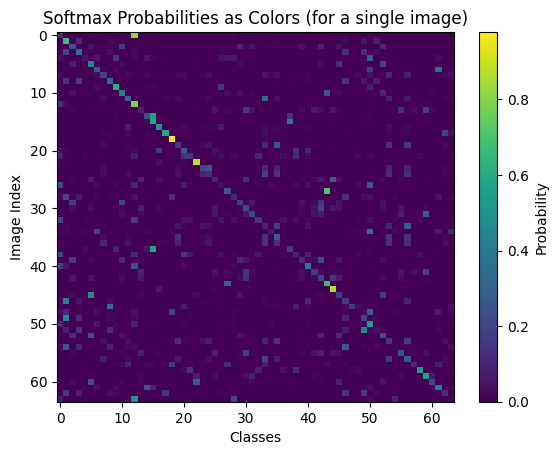

In [ ]:
import matplotlib.pyplot as plt
model = model.to("cuda")

torch.cuda.empty_cache()

images, text = next(iter(test_dataloader))
inputs = processor(text=text, images=images, return_tensors="pt", padding=True, do_rescale=False)
inputs = inputs.to(device)

outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
logits_per_text = outputs.logits_per_text

probs = logits_per_image.softmax(dim=1)  # Softmax to get probabilities


# Create a grid plot for the probabilities (interpreting it as a color-coded heatmap)
plt.imshow(probs.cpu().detach().numpy(), cmap='viridis', aspect='auto')  # Reshape into a 1D grid
plt.colorbar(label='Probability')
plt.title("Softmax Probabilities as Colors (for a single image)")
plt.xlabel("Classes")
plt.ylabel("Image Index")
plt.show()